**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import time, math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import nltk
import string
import unidecode
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from nltk.stem import WordNetLemmatizer

**Data preparation**

In [2]:
data = pd.read_csv('Shakespeare_data.csv')
data = data.rename(columns={'PlayerLine': 'text'})
data.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,text
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [3]:
# Let us keep only the column that we need for model training, text generation

data = data['text']
length = len(data)
print(f"There are {length} sentences in dataset.", '\n')
data.head()

There are 111396 sentences in dataset. 



0                                                ACT I
1                         SCENE I. London. The palace.
2    Enter KING HENRY, LORD JOHN OF LANCASTER, the ...
3               So shaken as we are, so wan with care,
4           Find we a time for frighted peace to pant,
Name: text, dtype: object

**GPU checking**

In [4]:
# Check if GPU is available to do the training with it for faster calculations
# otherwise use CPU

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("GPU is found and connected!")
elif torch.cuda.is_available():
    device = torch.cuda.device(0)
else:
    device = torch.device("cpu")
    print("No GPU, will do training with CPU")

GPU is found and connected!


In [5]:
len(data)

111396

**Data preprocessing**

In [6]:
text = list(data[:5000]) #[:100]

# Define function to join all sentences into one long sentence
def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)

# number of words in our data
len(text.split())

37805

In [7]:
text.split()

['ACT',
 'I',
 'SCENE',
 'I.',
 'London.',
 'The',
 'palace.',
 'Enter',
 'KING',
 'HENRY,',
 'LORD',
 'JOHN',
 'OF',
 'LANCASTER,',
 'the',
 'EARL',
 'of',
 'WESTMORELAND,',
 'SIR',
 'WALTER',
 'BLUNT,',
 'and',
 'others',
 'So',
 'shaken',
 'as',
 'we',
 'are,',
 'so',
 'wan',
 'with',
 'care,',
 'Find',
 'we',
 'a',
 'time',
 'for',
 'frighted',
 'peace',
 'to',
 'pant,',
 'And',
 'breathe',
 'short-winded',
 'accents',
 'of',
 'new',
 'broils',
 'To',
 'be',
 'commenced',
 'in',
 'strands',
 'afar',
 'remote.',
 'No',
 'more',
 'the',
 'thirsty',
 'entrance',
 'of',
 'this',
 'soil',
 'Shall',
 'daub',
 'her',
 'lips',
 'with',
 'her',
 'own',
 "children's",
 'blood,',
 'Nor',
 'more',
 'shall',
 'trenching',
 'war',
 'channel',
 'her',
 'fields,',
 'Nor',
 'bruise',
 'her',
 'flowerets',
 'with',
 'the',
 'armed',
 'hoofs',
 'Of',
 'hostile',
 'paces:',
 'those',
 'opposed',
 'eyes,',
 'Which,',
 'like',
 'the',
 'meteors',
 'of',
 'a',
 'troubled',
 'heaven,',
 'All',
 'of',
 'on

In [8]:
# Define stopwords and punctuation marks to remove them from data

stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()

def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
    
# filltered sentences without stopwords, punctuations in lemmatized and lowercased 
test_sentence = clean(text).lower().split()

In [9]:
# Trigrams are a type of n-gram, which are contiguous sequences of n items (words in the context of text)
# trigrams are a valuable tool in text analysis because they help to capture local word dependencies

trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len = len(trigrams)
print(chunk_len)
print(trigrams[:3])

24484
[(['act', 'i'], 'scene'), (['i', 'scene'], 'i'), (['scene', 'i'], 'london')]


In [10]:
# Define vocubalary based on data and assign numeric value to each unique word

vocab = set(test_sentence)
voc_len = len(vocab)
print(f'There are {voc_len} unique words in dataset.')

word_to_ix = {word: i for i, word in enumerate(vocab)}

There are 5016 unique words in dataset.


In [11]:
# Define input and target pairs to train a neural network for tasks text generation

inp = []
tar = []

for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [24]:
# code for saving, loading above defined input, target

# torch.save(inp, 'inp.pt')
# torch.save(tar, 'tar.pt')

# inp = torch.load('inp.pt', map_location=torch.device('mps'))
# tar = torch.load('tar.pt', map_location=torch.device('mps'))

In [12]:
# Define PyTorch RNN model

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # embed the input data into continuous vector of size hidden_size
        self.encoder = nn.Embedding(input_size, hidden_size)
        # model uses bidirectional encoding, it receives both forward and backward hidden states concatenated
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        # project the hidden state output of the RNN into the output space
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    # initializes the hidden state as a tensor of zeros
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [13]:
# Define a training function for the RNN model

def train(inp, target):
    hidden = decoder.init_hidden().to(device)
    # resets the gradients of the model's parameters to zero
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].to(device), hidden)
        loss += criterion(output, target[c].to(device))

    loss.backward()
    # updates the model's parameters using the computed gradients
    decoder_optimizer.step()

    # returns the average loss per step 
    return loss.data.item() / chunk_len

In [14]:
# Calculate training time

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The below code is for training the above defined model. I have already trained the model for 300 epochs and saved it under name 'decoder_model'.

Let us load the model and test it.

In [15]:
# # Start training process of RNN model

# n_epochs = 300
# print_every = 10
# plot_every = 10
# hidden_size = 10
# n_layers = 5
# lr = 0.015

# decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
# decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
# criterion = nn.CrossEntropyLoss()

# start = time.time()
# all_losses = []
# loss_avg = 0
# decoder.to(device)
# for epoch in range(1, n_epochs + 1):
#     loss = train(inp,tar)       
#     loss_avg += loss

#     if epoch % print_every == 0:
#         print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
# #         print(evaluate('ge', 200), '\n')

#     if epoch % plot_every == 0:
#         all_losses.append(loss_avg / plot_every)
#         loss_avg = 0

 19s (10 1%) 7.6813]
 57s (20 3%) 7.3095]
 31s (30 5%) 7.2676]
 20s (40 6%) 7.2507]
 14s (50 8%) 7.2441]
 33s (60 10%) 7.2420]
 37s (70 11%) 7.2411]
 38s (80 13%) 7.2409]
 23s (90 15%) 7.2408]
 14s (100 16%) 7.2407]
 8s (110 18%) 7.2407]
 42s (120 20%) 7.2403]
 44s (130 21%) 7.2401]
 31s (140 23%) 7.2396]
 16s (150 25%) 7.2390]
 19s (160 26%) 7.2382]
 10s (170 28%) 7.2368]
 17s (180 30%) 7.2349]
 18s (190 31%) 7.2325]
 20s (200 33%) 7.2293]
 36s (210 35%) 7.2260]
 12s (220 36%) 7.2223]
 34s (230 38%) 7.2187]
 23s (240 40%) 7.2155]
 27s (250 41%) 7.2126]
 4s (260 43%) 7.2098]
 36s (270 45%) 7.2074]
[1046m 35s (280 46%) 7.2056]
[1178m 1s (290 48%) 7.2037]
[1323m 33s (300 50%) 7.2020]


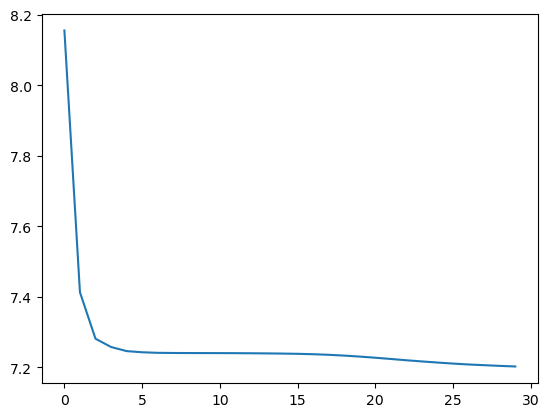

In [17]:
# Visualize loss function decrease

plt.figure()
plt.plot(all_losses)

In [18]:
# Define a function called evaluate that uses a trained RNN language model (decoder) to generate text 
# based on an initial input string prime_str
# function generates text by predicting the next word in the sequence and iteratively appending it to the input string

def evaluate(prime_str='king keeps', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().to(device)

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).to(device)
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

*Some explanation about the effect of Temperature*:

High Temperature (e.g., > 1.0): When the temperature is set to a high value, it increases the likelihood of selecting words with lower scores, making the text generation more random. This means that less likely words have a higher chance of being chosen, leading to more diverse and creative text. However, the text may become less coherent and less focused.


Intermediate Temperature (e.g., ~ 1.0): At an intermediate temperature provides a balance between randomness and focusing on likely words. It often results in text that is both creative and coherent.


Low Temperature (e.g., < 1.0): When the temperature is set to a low value, it sharpens the distribution, emphasizing words with higher scores and reducing the randomness in text generation. This leads to more deterministic and focused text, with a tendency to stick to more probable words.

In [22]:
print(evaluate('i am', 40, temperature=1.2))

i am host northumberland sphere theme so meet like nimble thou wa in kind planet side sun night walter brought temperd john accent illsheathed scots son meteor business two irregular thou improvident crowned of in shape uneven posterity head coz power no


In [28]:
# # Specify the path where you want to save the model
# model_path = 'decoder_model'

# # Save the model's state_dict
# torch.save(decoder.state_dict(), model_path)

In [27]:
torch.load('decoder_model')

OrderedDict([('encoder.weight',
              tensor([[-0.5051, -1.0201,  0.3953,  ...,  0.2292, -0.1467, -0.7367],
                      [-0.9352,  1.6367, -0.8942,  ...,  1.1072,  0.0025,  1.7083],
                      [ 0.7627,  0.1615,  0.6916,  ...,  0.8596, -1.1878, -1.1211],
                      ...,
                      [-0.2016, -0.7770, -0.0555,  ..., -0.8676,  0.4075, -0.1264],
                      [ 0.4194,  0.6764, -0.0937,  ...,  1.5796,  0.5211, -0.2843],
                      [-0.0681, -0.7330,  0.5209,  ..., -0.5770,  0.4956, -0.1032]],
                     device='mps:0')),
             ('gru.weight_ih_l0',
              tensor([[-2.0722e-01, -2.8548e-01, -1.5832e-02,  7.7778e-02,  4.3522e-01,
                       -3.0609e-01, -1.2243e-01, -3.5237e-01, -1.3664e-01, -2.4907e-01,
                        4.4477e-02, -4.0722e-01, -4.9795e-01, -3.3928e-01, -2.2377e-01,
                        4.0264e-01,  9.3008e-02, -1.2395e-02,  1.7594e-01, -3.8255e-03],
          